# Example

In [1]:
import banditpylib
import numpy as np
import json
import pprint
from matplotlib.pyplot import figure
from tabulate import tabulate

## Use policies in library

In [2]:
config_file = 'config.json'
# load config file
with open(config_file, 'r') as json_file:
    config = json.load(json_file)

In [3]:
pprint.pprint(config)

{'environment': {'bandit': 'OrdinaryBandit',
                 'params': {'arm': 'BernoulliArm', 'means': [0.3, 0.5, 0.7]}},
 'learners': {'goal': 'regretmin',
              'policies': [{'params': {'name': 'Uniform Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'Uniform'},
                           {'params': {'name': 'UCB1',
                                       'type': 'ordinarylearner'},
                            'policy': 'UCB'},
                           {'params': {'horizon': 2000,
                                       'type': 'ordinarylearner'},
                            'policy': 'MOSS'},
                           {'params': {'name': 'Thompson Sampling',
                                       'type': 'ordinarylearner'},
                            'policy': 'TS'}]},
 'running': {'freq': 20, 'horizon': 2000, 'processors': -1, 'trials': 200}}


In [4]:
# add `debug=True` in the arguments if you want more detailed runtime info or try to debug
data = banditpylib.run(config)

I0312 15:44:30.651861 4704452032 __init__.py:223] run with goal Regret Minimization
I0312 15:44:30.653589 4704452032 utils.py:120] run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
I0312 15:44:32.451601 4704452032 utils.py:130] 1.80 seconds elapsed
I0312 15:44:32.454101 4704452032 utils.py:120] run UCB1 with protocol SinglePlayerRegretMinProtocol
I0312 15:44:36.910399 4704452032 utils.py:130] 4.45 seconds elapsed
I0312 15:44:36.912863 4704452032 utils.py:120] run MOSS with protocol SinglePlayerRegretMinProtocol
I0312 15:44:41.998381 4704452032 utils.py:130] 5.08 seconds elapsed
I0312 15:44:42.003381 4704452032 utils.py:120] run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
I0312 15:44:45.750046 4704452032 utils.py:130] 3.74 seconds elapsed


I0312 15:44:46.007006 4704452032 utils.py:141] NumExpr defaulting to 8 threads.


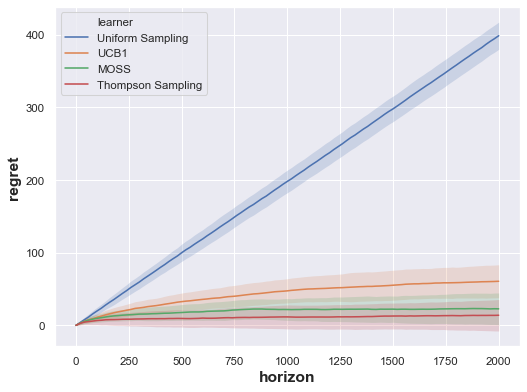

In [5]:
figure(figsize=(8, 6), dpi=75)
# add `save_fig=FILEPATH` in the arguments if you want to save the figure
df = banditpylib.plot(data)

In [6]:
print(tabulate(df.head(), headers=["policy", "regret"]))

policy          regret
------------  --------
('MOSS', 0)      0
('MOSS', 20)     3.235
('MOSS', 40)     5.45
('MOSS', 60)     7.205
('MOSS', 80)     8.65


## Add a new policy

In [7]:
from banditpylib.learners.regretmin import ordinarylearner

In [8]:
# time starts from 1
# arm index starts from 0
# self._t and self._em_arms are inherited from parent class
class ExploreThenCommit(ordinarylearner.OrdinaryLearner):
  def __init__(self, pars):
    super().__init__(pars)
    self.__T_zero = pars['T_zero']

  @property
  def name(self):
    return 'Explore-Then-Commit'

  def _learner_reset(self):
    # called before the start of the game
    self.__commit = None

  def learner_step(self, context):
    # during each time step, this method will be called automatically by the protocol
    # context is useless
    del context
    if self._t <= self.__T_zero:
        # pull each arm in a round-robin way
        return (self._t-1) % self._arm_num
    if not self.__commit:
        self.__commit = np.argmax([em_arm.em_mean for em_arm in self._em_arms])
    return self.__commit

  def _learner_update(self, context, action, feedback):
    # called after each time step reward is revealed
    pass

In [9]:
# when 'ind_run' is set True, all points in the figure will be independent, which means
# for each t in figure, we will run an independent trial
policies = [ExploreThenCommit({'T_zero': 100, 'ind_run': True})]

In [10]:
data = banditpylib.run(config, new_policies=policies)

I0312 15:44:46.584932 4704452032 __init__.py:223] run with goal Regret Minimization
I0312 15:44:46.585997 4704452032 utils.py:120] run Uniform Sampling with protocol SinglePlayerRegretMinProtocol
I0312 15:44:48.362160 4704452032 utils.py:130] 1.78 seconds elapsed
I0312 15:44:48.365166 4704452032 utils.py:120] run UCB1 with protocol SinglePlayerRegretMinProtocol
I0312 15:44:53.209718 4704452032 utils.py:130] 4.84 seconds elapsed
I0312 15:44:53.212460 4704452032 utils.py:120] run MOSS with protocol SinglePlayerRegretMinProtocol
I0312 15:44:58.397213 4704452032 utils.py:130] 5.18 seconds elapsed
I0312 15:44:58.400125 4704452032 utils.py:120] run Thompson Sampling with protocol SinglePlayerRegretMinProtocol
I0312 15:45:02.544842 4704452032 utils.py:130] 4.14 seconds elapsed
I0312 15:45:02.547585 4704452032 utils.py:120] run Explore-Then-Commit with protocol SinglePlayerRegretMinProtocol
I0312 15:46:37.569797 4704452032 utils.py:130] 95.02 seconds elapsed


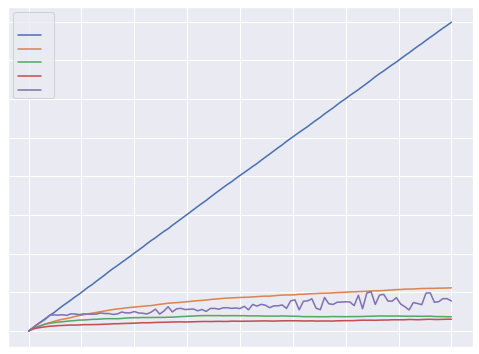

In [11]:
figure(figsize=(8, 6), dpi=75)
df = banditpylib.plot(data, novar=True)